# Trabajo Práctico 2 - Organización de Datos
## Competencia de Machine Learning
### Facultad de Ingeniería de la Universidad de Buenos Aires
### 95-58: Organización de Datos - 2do Cuat. 2018

#### Integrantes: Gonzalo Diz,  Ariel Windey, Gabriel Robles y Matías Ramundo




#### Objetivo
Determinar, para cada usuario presentado, cuál es la probabilidad de que ese
usuario realice una conversión en Trocafone en un periodo determinado.

#### Fuentes
El archivo "events_up_to_01062018.csv" contiene en el mismo formato utilizado en el TP1
información de eventos realizado en la plataforma para un conjunto de usuarios hasta el
31/05/2018.

Por otro lado el archivo "labels_training_set.csv" indica para un subconjunto de los
usuarios incluidos en el set de eventos "events_up_to_01062018.csv" si los mismos
realizaron una conversión (columna label = 1) o no (columna label = 0) desde el 01/06/2018
hasta el 15/06/2018.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl

%matplotlib inline

pd.set_option('display.max_columns', 200)

In [2]:
# Carga del set de datos de eventos
events = pd.read_csv('../dataset/events_up_to_01062018.csv', low_memory=False)
# Carga del set de datos de labels
labels = pd.read_csv('../dataset/labels_training_set.csv', low_memory=False)


In [3]:
events.shape

(2341681, 23)

Agregamos al dataframe de eventos la columna de labels

In [4]:
eventos = events.merge(labels, on='person', how='left')

In [5]:
eventos.label.value_counts()

0.0    1072202
1.0      99684
Name: label, dtype: int64

In [6]:
eventos.event.value_counts()

viewed product       1248124
brand listing         216312
visited site          204069
ad campaign hit       191388
generic listing       160176
searched products     130616
search engine hit     106406
checkout               65315
staticpage             11201
conversion              7091
lead                     983
Name: event, dtype: int64

In [7]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,label
2287157,2018-05-24 20:56:50,visited site,d61f25bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paid,Returning,Sao Jose,Santa Catarina,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 66.0,0.0
1300149,2018-05-09 21:31:19,viewed product,78731769,NaN,4956.0,Motorola Moto G2 4G Dual,Muito Bom,16GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2234506,2018-01-27 02:47:47,visited site,aacd5367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Referral,Returning,Natal,Rio Grande do Norte,Brazil,Smartphone,360x640,Android 6.0.1,Chrome Mobile 63.0,0.0
2185013,2018-03-14 19:32:17,visited site,4de76b31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Referral,Returning,Belo Horizonte,Minas Gerais,Brazil,Smartphone,360x640,Android 7.1.1,Chrome Mobile 64.0,NaN
569436,2018-05-04 01:45:53,viewed product,56d09278,NaN,10380.0,Motorola Moto G4 Plus,Excelente,32GB,Bambu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Agregamos campos de fecha como en el TP 1
eventos['timestamp'] = pd.to_datetime(eventos['timestamp'])
eventos['hour'] = eventos['timestamp'].dt.hour
eventos['month'] = eventos['timestamp'].dt.month
eventos['week_year'] = eventos['timestamp'].dt.weekofyear
eventos['year'] = eventos['timestamp'].dt.year
eventos['day_week'] = eventos['timestamp'].dt.dayofweek
eventos['day_year'] = eventos.timestamp.dt.dayofyear
eventos['month_day'] = eventos['timestamp'].dt.day

days_of_year = eventos.day_year.unique()
print("Tenemos datos de", days_of_year.size, "dias distintos del anio")
# Creamos la columna de fin de semana
eventos['is_weekend'] = ((eventos.day_week == 5) | (eventos.day_week == 6))

Tenemos datos de 151 dias distintos del anio


In [9]:
# Obtenemos un frame con solo los usuarios donde iremos mergeando los features
persons = eventos.person.to_frame().drop_duplicates()

### Región geográfica
Agregamos la región geográfica al igual que en el TP 1, para saber desde donde acceden más los distintos usuarios.

In [10]:
# Categorizamos las regiones geograficamente
eventos['geo_region'] = 0

eventos.loc[
    (eventos['region'] == 'Sao Paulo') |
    (eventos['region'] == 'Rio de Janeiro') |
    (eventos['region'] == 'Minas Gerais') |
    (eventos['region'] == 'Espirito Santo'), 
    'geo_region'
] = 'southeast'

eventos.loc[
    (eventos['region'] == 'Parana') |
    (eventos['region'] == 'Rio Grande do Sul') |
    (eventos['region'] == 'Santa Catarina'), 
    'geo_region'
] = 'south'

eventos.loc[
    (eventos['region'] == 'Federal District') |
    (eventos['region'] == 'Goias') |
    (eventos['region'] == 'Mato Grosso do Sul') |
    (eventos['region'] == 'Mato Grosso'), 
    'geo_region'
] = 'center west'

eventos.loc[
    (eventos['region'] == 'Bahia') |
    (eventos['region'] == 'Pernambuco') |
    (eventos['region'] == 'Ceara') |
    (eventos['region'] == 'Maranhao') |
    (eventos['region'] == 'Rio Grande do Norte') |
    (eventos['region'] == 'Paraíba') |
    (eventos['region'] == 'Piaui') |
    (eventos['region'] == 'Alagoas') |
    (eventos['region'] == 'Sergipe'), 
    'geo_region'
] = 'northeast'

eventos.loc[
    (eventos['region'] == 'Para') |
    (eventos['region'] == 'Amazonas') |
    (eventos['region'] == 'Tocantins') |
    (eventos['region'] == 'Amapa') |
    (eventos['region'] == 'Rondonia') |
    (eventos['region'] == 'Acre') |
    (eventos['region'] == 'Roraima'), 
    'geo_region'
] = 'north'

In [11]:
eventos.geo_region.value_counts()

0              2172865
southeast        97323
northeast        40903
south            14242
center west       9249
north             7099
Name: geo_region, dtype: int64

Creamos columnas booleanas sobre las regiones geograficas para luego agrupar por usuarios.

In [97]:
eventos['cant_accesos_southeast'] = (eventos.geo_region == 'southeast').astype(int)
eventos['cant_accesos_northeast'] = (eventos.geo_region == 'northeast').astype(int)
eventos['cant_accesos_south'] = (eventos.geo_region == 'south').astype(int)
eventos['cant_accesos_center_west'] = (eventos.geo_region == 'center west').astype(int)
eventos['cant_accesos_north'] = (eventos.geo_region == 'north').astype(int)

In [107]:
personas_y_accesos_por_region = eventos.groupby(['person']).agg({
    'cant_accesos_southeast': 'sum', 
    'cant_accesos_northeast': 'sum', 
    'cant_accesos_south': 'sum', 
    'cant_accesos_center_west': 'sum', 
    'cant_accesos_north': 'sum'
})
personas_y_accesos_por_region.head(5)

,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north
person,,,,,
0008ed71,0,0,0,0,0
00091926,0,0,34,0,0
00091a7a,1,0,0,0,0
000ba417,6,0,0,0,0
000c79fe,1,0,0,0,0


# Región geográfica de los usuarios
Veremos la región geográfica de los usuarios clasificándolos por la región desde la cual tengan mayor cantidad de eventos.

In [108]:
df = personas_y_accesos_por_region
df['origen_usuario'] = df.idxmax(axis=1)
df.loc[
    (df['origen_usuario'] == 'cant_accesos_southeast') , 
    'origen_usuario'
] = 'southeast'
df.loc[
    (df['origen_usuario'] == 'cant_accesos_northeast') , 
    'origen_usuario'
] = 'northeast'
df.loc[
    (df['origen_usuario'] == 'cant_accesos_south') , 
    'origen_usuario'
] = 'south'
df.loc[
    (df['origen_usuario'] == 'cant_accesos_center_west') , 
    'origen_usuario'
] = 'center weast'
df.loc[
    (df['origen_usuario'] == 'cant_accesos_north') , 
    'origen_usuario'
] = 'north'
personas_y_accesos_por_region = df.reset_index()
personas_y_accesos_por_region.head()

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,origen_usuario
0,0008ed71,0,0,0,0,0,southeast
1,00091926,0,0,34,0,0,south
2,00091a7a,1,0,0,0,0,southeast
3,000ba417,6,0,0,0,0,southeast
4,000c79fe,1,0,0,0,0,southeast


Text(0,0.5,'Porcentaje')

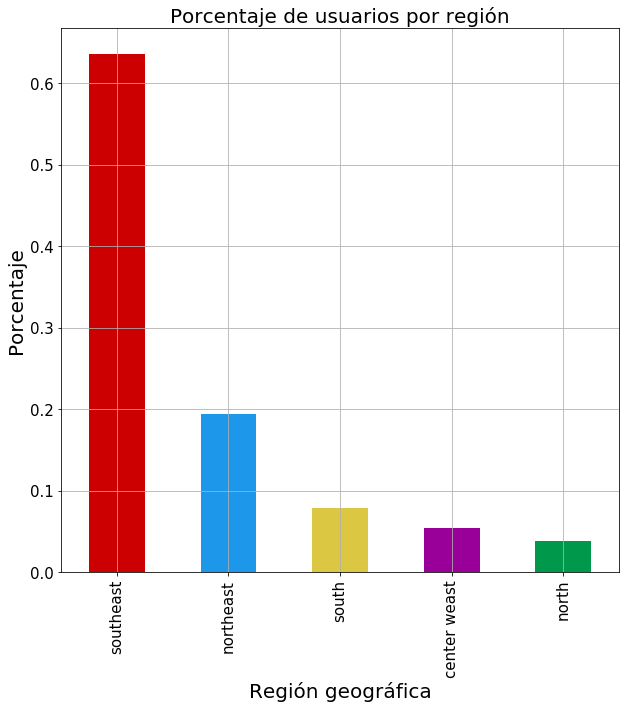

In [115]:
plot = personas_y_accesos_por_region.origen_usuario.value_counts(normalize=True).plot.bar(fontsize=15, grid=True, figsize=(10,10), color=['#CC0000', '#1D97E9', '#DBC742', '#990099', '#00994C'])
plot.set_title("Porcentaje de usuarios por región", fontsize=20)
plot.set_xlabel("Región geográfica", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)

Agregamos este nuevo feature a nuestro dataframe de features.

In [14]:
user_features = persons.merge(personas_y_accesos_por_region, how='inner', on='person')
user_features.head(5)

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north
0,4886f805,1,0,0,0,0
1,ad93850f,5,0,0,0,0
2,0297fc1e,95,0,0,0,0
3,2d681dd8,2,0,0,0,0
4,cccea85e,22,0,0,0,0


In [15]:
personas_y_times = eventos.groupby(['person']).agg({
    'timestamp': ['min', 'max']
})
personas_y_times.reset_index(inplace=True)
personas_y_times.columns = ['person', 'time_first_event', 'time_last_event']
personas_y_times.head()

,person,time_first_event,time_last_event
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07


Agrego la cantidad de días al primer evento del año del usuario, usando como fecha para calcular las diferencias el 1 de junio de 2018 (dato del enunciado).

In [16]:
last_date = pd.to_datetime("2018/06/01")
personas_y_times['how_long_ago_was_first_event'] = (last_date - personas_y_times.time_first_event)
personas_y_times['how_long_ago_was_last_event'] = (last_date - personas_y_times.time_last_event)
personas_y_times['first_and_last_event_distance'] = (personas_y_times.time_last_event - personas_y_times.time_first_event)
personas_y_times.head()

,person,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37,14 days 11:32:13,14 days 07:31:23,0 days 04:00:50
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03,28 days 01:51:31,0 days 04:07:57,27 days 21:43:34
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58,66 days 09:08:49,66 days 09:03:02,0 days 00:05:47
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22,14 days 12:48:15,5 days 10:50:38,9 days 01:57:37
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07,2 days 23:32:13,2 days 23:21:53,0 days 00:10:20


Queremos ver la frecuencia de eventos de los usuarios y para ello queremos saber la cantidad total de eventos que genero cada usuario


In [17]:
# Agrego cantidad total de eventos que hizo cada usuario
eventos['cant_total_eventos'] = 1
cant_total_eventos_por_usuario = eventos.groupby(['person']).agg({'cant_total_eventos': 'sum'}).reset_index()
cant_total_eventos_por_usuario.head()

,person,cant_total_eventos
0,0008ed71,6
1,00091926,448
2,00091a7a,10
3,000ba417,206
4,000c79fe,17


In [18]:
personas_times_y_eventos_totales = personas_y_times.merge(cant_total_eventos_por_usuario, how='inner', on='person')
personas_times_y_eventos_totales.head()

,person,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37,14 days 11:32:13,14 days 07:31:23,0 days 04:00:50,6
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03,28 days 01:51:31,0 days 04:07:57,27 days 21:43:34,448
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58,66 days 09:08:49,66 days 09:03:02,0 days 00:05:47,10
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22,14 days 12:48:15,5 days 10:50:38,9 days 01:57:37,206
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07,2 days 23:32:13,2 days 23:21:53,0 days 00:10:20,17


Pasamos la distancia entre el primer y el último evento del usuario a "días" (sumando 1 para los casos que hay 0 días de distancia). Con esto podremos dividir la cantidad de eventos totales sobre esta distancia para obtener la "cantidad promedio de eventos por día por usuario".

In [19]:
personas_times_y_eventos_totales['first_and_last_event_distance_in_days'] = personas_times_y_eventos_totales.first_and_last_event_distance.dt.days + 1
personas_times_y_eventos_totales['mean_events_per_day'] = personas_times_y_eventos_totales.cant_total_eventos / personas_times_y_eventos_totales.first_and_last_event_distance_in_days
personas_times_y_eventos_totales.head()

,person,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day
0,0008ed71,2018-05-17 12:27:47,2018-05-17 16:28:37,14 days 11:32:13,14 days 07:31:23,0 days 04:00:50,6,1,6.0
1,00091926,2018-05-03 22:08:29,2018-05-31 19:52:03,28 days 01:51:31,0 days 04:07:57,27 days 21:43:34,448,28,16.0
2,00091a7a,2018-03-26 14:51:11,2018-03-26 14:56:58,66 days 09:08:49,66 days 09:03:02,0 days 00:05:47,10,1,10.0
3,000ba417,2018-05-17 11:11:45,2018-05-26 13:09:22,14 days 12:48:15,5 days 10:50:38,9 days 01:57:37,206,10,20.6
4,000c79fe,2018-05-29 00:27:47,2018-05-29 00:38:07,2 days 23:32:13,2 days 23:21:53,0 days 00:10:20,17,1,17.0


(0, 100)

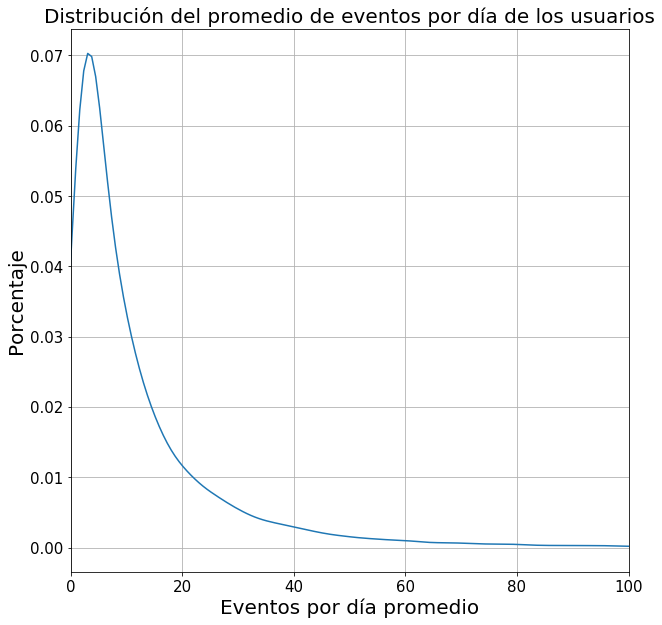

In [123]:
plot = personas_times_y_eventos_totales.mean_events_per_day.plot.density(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Distribución del promedio de eventos por día de los usuarios", fontsize=20)
plot.set_xlabel("Eventos por día promedio", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)
plot.set_xlim([0, 100])

Aquí pudimos observar la distribución de 'promedio de eventos por día' para todos los usuarios. Para distinguir si este *feature* tiene importancia en cuanto a conversiones, mediremos la distribución de la misma variable para los usuarios que sabemos si compraron o no en junio

In [124]:
si_compraron = labels.loc[labels.label == 1]
si_compraron.head()

,person,label
5,db2c4d27,1
25,8123457d,1
46,e4b02ea2,1
48,d8001b23,1
54,7a472832,1


In [125]:
no_compraron = labels.loc[labels.label == 0]
no_compraron.head()

,person,label
0,0566e9c1,0
1,6ec7ee77,0
2,abe7a2fb,0
3,34728364,0
4,87ed62de,0


(0, 100)

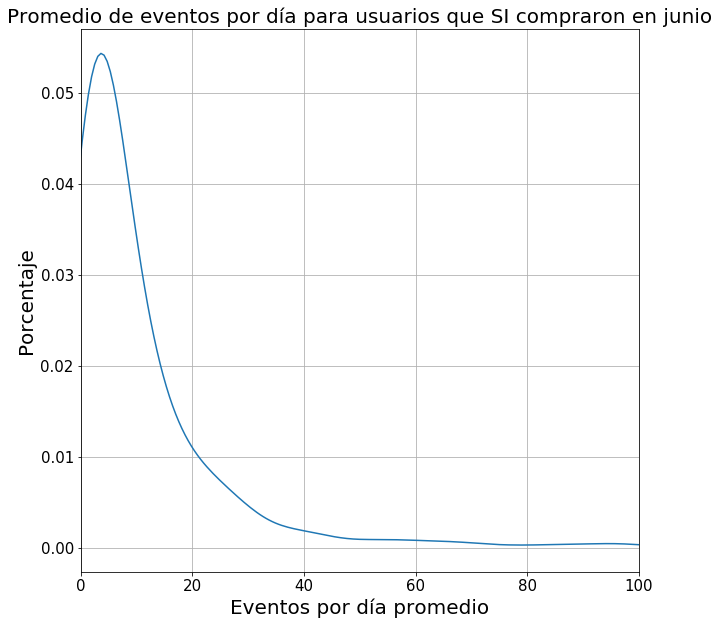

In [139]:
eventos_promedio_si_compraron = personas_times_y_eventos_totales.merge(si_compraron, on='person', how='inner')
plot = eventos_promedio_si_compraron.mean_events_per_day.plot.density(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Promedio de eventos por día para usuarios que SI compraron en junio", fontsize=20)
plot.set_xlabel("Eventos por día promedio", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)
plot.set_xlim([0, 100])

(0, 100)

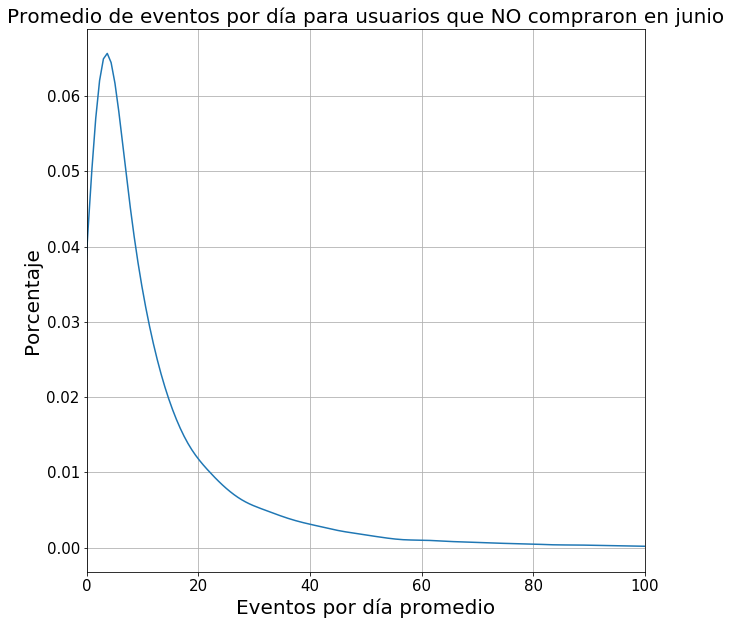

In [136]:
eventos_promedio_no_compraron = personas_times_y_eventos_totales.merge(no_compraron, on='person', how='inner')
plot = eventos_promedio_no_compraron.mean_events_per_day.plot.density(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Promedio de eventos por día para usuarios que NO compraron en junio", fontsize=20)
plot.set_xlabel("Eventos por día promedio", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)
plot.set_xlim([0, 100])

In [20]:
user_features2 = user_features.merge(personas_times_y_eventos_totales, how='inner', on='person')
# user_features2.to_csv('../dataset/features_ariel.csv')

Analizaremos la franja horaria de mayor uso de cada usuario. Para ello haremos la siguiente categorización de los eventos:
* Accesos de 00:00hs a 05:59hs serán **madrugada**
* Accesos de 06:00hs a 11:59hs serán **mañana**
* Accesos de 12:00hs a 17:59hs serán **tarde**
* Accesos de 18:00hs a 23:59hs serán **noche**


In [21]:
eventos['cant_ev_madrugada'] = ((eventos.hour >= 0) & (eventos.hour < 7)).astype(int)
eventos['cant_ev_manana'] = ((eventos.hour >= 7) & (eventos.hour < 12)).astype(int)
eventos['cant_ev_tarde'] = ((eventos.hour >= 12) & (eventos.hour < 18)).astype(int)
eventos['cant_ev_noche'] = ((eventos.hour >= 18) & (eventos.hour < 24)).astype(int)

In [22]:
eventos.cant_ev_madrugada.value_counts()

0    1815212
1     526469
Name: cant_ev_madrugada, dtype: int64

In [23]:
eventos.cant_ev_manana.value_counts()

0    2182460
1     159221
Name: cant_ev_manana, dtype: int64

In [24]:
eventos.cant_ev_tarde.value_counts()

0    1524261
1     817420
Name: cant_ev_tarde, dtype: int64

In [25]:
eventos.cant_ev_noche.value_counts()

0    1503110
1     838571
Name: cant_ev_noche, dtype: int64

In [140]:
df = eventos.groupby(['person']).agg({
    'cant_ev_madrugada': 'sum',
    'cant_ev_manana': 'sum',
    'cant_ev_tarde': 'sum',
    'cant_ev_noche': 'sum'
})
df['franja_horaria_moda'] = df.idxmax(axis=1)
df.loc[
    (df['franja_horaria_moda'] == 'cant_ev_manana') , 
    'franja_horaria_moda'
] = 'manana'
df.loc[
    (df['franja_horaria_moda'] == 'cant_ev_tarde') , 
    'franja_horaria_moda'
] = 'tarde'
df.loc[
    (df['franja_horaria_moda'] == 'cant_ev_noche') , 
    'franja_horaria_moda'
] = 'noche'
df.loc[
    (df['franja_horaria_moda'] == 'cant_ev_madrugada') , 
    'franja_horaria_moda'
] = 'madrugada'

usuarios_y_cant_eventos_por_franja_horaria = df.reset_index()
usuarios_y_cant_eventos_por_franja_horaria.head()

,person,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,franja_horaria_moda
0,0008ed71,0,0,6,0,tarde
1,00091926,313,0,0,135,madrugada
2,00091a7a,0,0,10,0,tarde
3,000ba417,0,57,149,0,tarde
4,000c79fe,17,0,0,0,madrugada


Realizaremos el plot de este *feature* tanto de manera genérica como con usuarios compradores y no compradores.

Text(0,0.5,'Porcentaje')

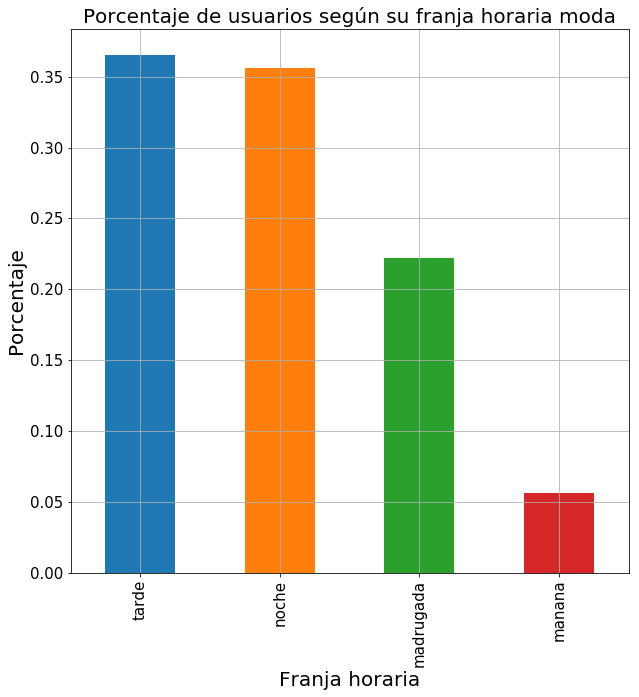

In [141]:
plot = usuarios_y_cant_eventos_por_franja_horaria.franja_horaria_moda.value_counts(normalize=True).plot.bar(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Porcentaje de usuarios según su franja horaria moda", fontsize=20)
plot.set_xlabel("Franja horaria", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)

(980, 7)


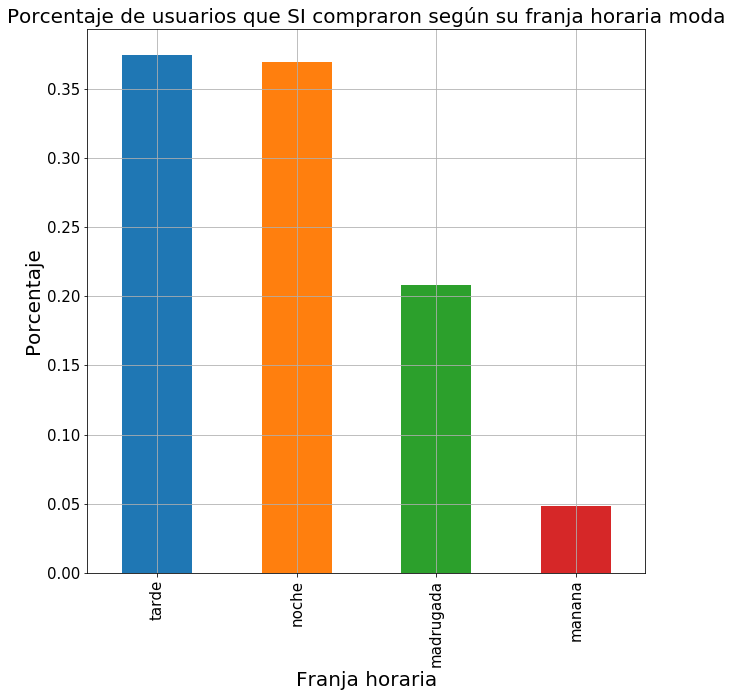

In [147]:
franja_horaria_si_compraron = usuarios_y_cant_eventos_por_franja_horaria.merge(si_compraron, how='inner', on='person')
plot = franja_horaria_si_compraron.franja_horaria_moda.value_counts(normalize=True).plot.bar(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Porcentaje de usuarios que SI compraron según su franja horaria moda", fontsize=20)
plot.set_xlabel("Franja horaria", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)
print(franja_horaria_si_compraron.shape)

(18434, 7)


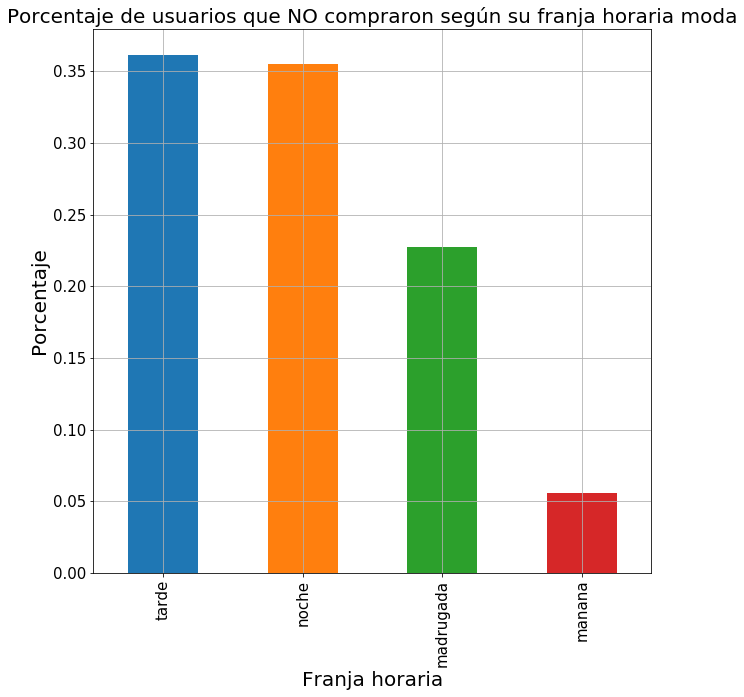

In [148]:
franja_horaria_no_compraron = usuarios_y_cant_eventos_por_franja_horaria.merge(no_compraron, how='inner', on='person')
plot = franja_horaria_no_compraron.franja_horaria_moda.value_counts(normalize=True).plot.bar(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Porcentaje de usuarios que NO compraron según su franja horaria moda", fontsize=20)
plot.set_xlabel("Franja horaria", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)
print(franja_horaria_no_compraron.shape)

Podemos ver como para el caso de no compradores hay una mayor cantidad en madrugada y mañana.

In [149]:
usuarios_y_cant_eventos_por_franja_horaria.franja_horaria_moda.value_counts()

tarde        14180
noche        13838
madrugada     8632
manana        2179
Name: franja_horaria_moda, dtype: int64

In [28]:
user_features3 = user_features2.merge(usuarios_y_cant_eventos_por_franja_horaria, how='inner', on='person')
user_features3
# user_features3.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,franja_horaria_moda
0,4886f805,1,0,0,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada
1,ad93850f,5,0,0,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada
2,0297fc1e,95,0,0,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,45,202,169,cant_ev_tarde
3,2d681dd8,2,0,0,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche
4,cccea85e,22,0,0,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,0,120,561,cant_ev_noche
5,4c8a8b93,20,0,0,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,2,81,67,cant_ev_madrugada
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,2,0,15,cant_ev_noche
7,29ebb414,4,0,0,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,0,9,6,cant_ev_madrugada
8,de8fe91b,2,0,0,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada


Analizaremos ahora el estado de los dispotivos moda de cada usuario

In [29]:
eventos.condition.value_counts()

Bom                   547617
Excelente             378697
Muito Bom             359053
Bom - Sem Touch ID     31742
Novo                    3421
Name: condition, dtype: int64

Agregaremos las columnas de cantidad de eventos para las distintas condiciones de los productos, para luego agrupar por usuario y sumar los totales.

In [30]:
eventos['cant_buenos'] = ((eventos.condition == 'Bom') | (eventos.condition == 'Bom - Sem Touch ID')).astype(int)
eventos['cant_excelentes'] = (eventos.condition == 'Excelente').astype(int)
eventos['cant_muy_buenos'] = (eventos.condition == 'Muito Bom').astype(int)
eventos['cant_nuevos'] = (eventos.condition == 'Novo').astype(int)

In [31]:
df = eventos.groupby(['person']).agg({
    'cant_buenos': 'sum',
    'cant_excelentes': 'sum',
    'cant_muy_buenos': 'sum',
    'cant_nuevos': 'sum'
})
df['condicion_de_producto_moda'] = df.idxmax(axis=1)
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_buenos') , 
    'condicion_de_producto_moda'
] = 'buenos'
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_excelentes') , 
    'condicion_de_producto_moda'
] = 'excelentes'
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_muy_buenos') , 
    'condicion_de_producto_moda'
] = 'muy buenos'
df.loc[
    (df['condicion_de_producto_moda'] == 'cant_nuevos') , 
    'condicion_de_producto_moda'
] = 'nuevos'
usuarios_y_condicion_producto = df.reset_index()
usuarios_y_condicion_producto.head(10)

,person,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,condicion_de_producto_moda
0,0008ed71,2,0,1,0,buenos
1,00091926,102,108,163,1,muy buenos
2,00091a7a,1,2,0,0,excelentes
3,000ba417,115,11,34,0,buenos
4,000c79fe,4,0,0,0,buenos
5,000e4d9e,124,53,163,0,muy buenos
6,000e619d,14,7,8,0,buenos
7,001001be,25,1,19,0,buenos
8,0010e89a,2,0,0,0,buenos
9,0016c4b5,2,0,0,0,buenos


In [32]:
user_features4 = user_features3.merge(usuarios_y_condicion_producto, how='inner', on='person')
user_features4
# user_features4.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,franja_horaria_moda,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,condicion_de_producto_moda
0,4886f805,1,0,0,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada,0,4,1,0,excelentes
1,ad93850f,5,0,0,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada,10,4,7,0,buenos
2,0297fc1e,95,0,0,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,45,202,169,cant_ev_tarde,246,46,119,0,buenos
3,2d681dd8,2,0,0,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche,14,0,0,0,buenos
4,cccea85e,22,0,0,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,0,120,561,cant_ev_noche,201,191,347,1,muy buenos
5,4c8a8b93,20,0,0,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,2,81,67,cant_ev_madrugada,62,76,39,2,excelentes
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,2,0,15,cant_ev_noche,8,0,2,0,buenos
7,29ebb414,4,0,0,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,0,9,6,cant_ev_madrugada,2,4,3,0,excelentes
8,de8fe91b,2,0,0,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada,8,8,12,0,muy buenos
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada,7,0,0,0,buenos


### Análisis de las conversiones según época del mes
Suponemos que en los primeros días del mes, los usuarios son más propensos a comprar dado que es cuando más plata tienen de su sueldo. Intentaremos de demostrar esto estudiando los eventos de conversión.

Primero dividiremos el mes en cuatro semanas

In [150]:
eventos['month_week'] = 0
eventos.loc[(eventos.month_day <= 8), 'month_week'] = 1
eventos.loc[((eventos.month_day > 8) & (eventos.month_day <= 15)), 'month_week'] = 2
eventos.loc[((eventos.month_day > 15) & (eventos.month_day <= 23)), 'month_week'] = 3
eventos.loc[((eventos.month_day > 23) & (eventos.month_day <= 31)), 'month_week'] = 4

In [151]:
eventos.month_week.value_counts()


4    889100
3    803147
2    379544
1    269890
Name: month_week, dtype: int64

In [152]:
conversiones = eventos.loc[(eventos.event == 'conversion'), ['event', 'month_week']]
conversiones.month_week.value_counts(normalize=True)

3    0.383021
4    0.374982
2    0.144408
1    0.097588
Name: month_week, dtype: float64

Text(0,0.5,'Porcentaje')

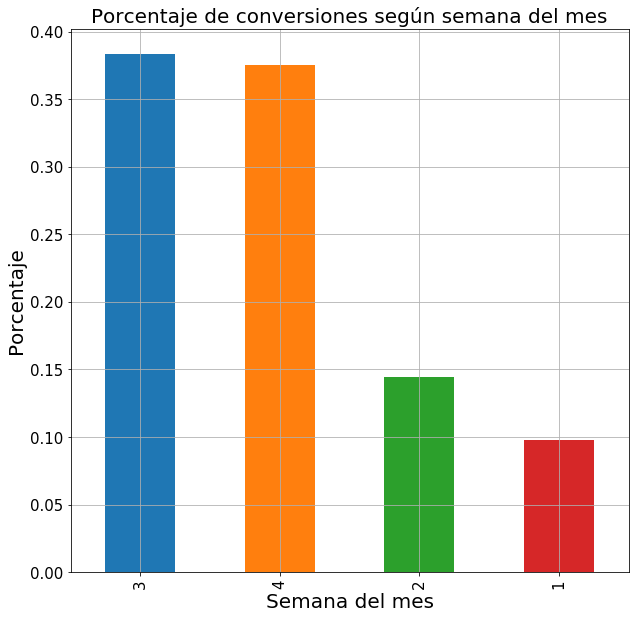

In [157]:
plot = conversiones.month_week.value_counts(normalize=True).plot.bar(fontsize=15, grid=True, figsize=(10,10))
plot.set_title("Porcentaje de conversiones según semana del mes", fontsize=20)
plot.set_xlabel("Semana del mes", fontsize=20)
plot.set_ylabel("Porcentaje", fontsize=20)

Contrario a lo que habíamos supuesto, podemos observar como más del 75% de las conversiones ocurren la segunda quincena de cada mes. Haremos un análisis de cómo evolucionaron estos porcentajes a lo largo de los cinco meses del año que tenemos información.

In [154]:
conversiones = eventos.loc[(eventos.event == 'conversion'), ['event', 'month', 'month_week']]
conversiones['primer_semana'] = (conversiones.month_week == 1).astype(int)
conversiones['segunda_semana'] = (conversiones.month_week == 2).astype(int)
conversiones['tercer_semana'] = (conversiones.month_week == 3).astype(int)
conversiones['cuarta_semana'] = (conversiones.month_week == 4).astype(int)
conversiones_por_mes = conversiones.groupby('month').agg({
    'primer_semana': 'sum',
    'segunda_semana': 'sum',
    'tercer_semana': 'sum',
    'cuarta_semana': 'sum',
    'month_week': 'size'
})

# Normalizamos para tener porcentajes
conversiones_por_mes.primer_semana = (conversiones_por_mes.primer_semana / conversiones_por_mes.month_week)
conversiones_por_mes.segunda_semana = (conversiones_por_mes.segunda_semana / conversiones_por_mes.month_week)
conversiones_por_mes.tercer_semana = (conversiones_por_mes.tercer_semana / conversiones_por_mes.month_week)
conversiones_por_mes.cuarta_semana = (conversiones_por_mes.cuarta_semana / conversiones_por_mes.month_week)
conversiones_por_mes.head()

,primer_semana,segunda_semana,tercer_semana,cuarta_semana,month_week
month,,,,,
1,0.217877,0.307263,0.223464,0.251397,179
2,0.275229,0.160550,0.339450,0.224771,218
3,0.226481,0.184669,0.294425,0.294425,574
4,0.265273,0.215434,0.218650,0.300643,622
5,0.054202,0.126228,0.417788,0.401782,5498


Hacemos una visualización de bar plots por grupos para ver más clara esta evolución

In [155]:
# Primero reordeno las columnas para que el plot este ordenado
conversiones_por_mes = conversiones_por_mes[['primer_semana', 'segunda_semana', 'tercer_semana', 'cuarta_semana', 'month_week']]
conversiones_por_mes.head()

,primer_semana,segunda_semana,tercer_semana,cuarta_semana,month_week
month,,,,,
1,0.217877,0.307263,0.223464,0.251397,179
2,0.275229,0.160550,0.339450,0.224771,218
3,0.226481,0.184669,0.294425,0.294425,574
4,0.265273,0.215434,0.218650,0.300643,622
5,0.054202,0.126228,0.417788,0.401782,5498


Text(0,0.5,'Porcentaje de conversiones del mes')

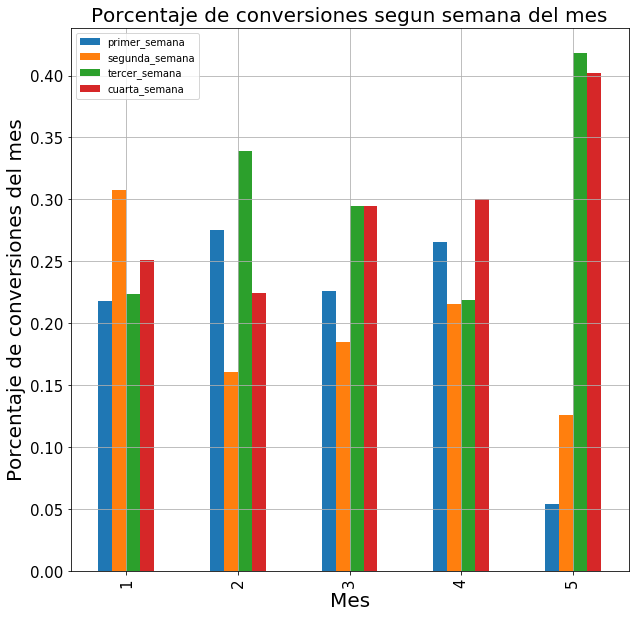

In [156]:
conversiones_por_semana_del_mes = conversiones_por_mes.drop(['month_week'], axis=1)
plot = conversiones_por_semana_del_mes.plot.bar(
    figsize=(10, 10), 
    fontsize=15,
    grid=True
)
plot.set_title("Porcentaje de conversiones segun semana del mes", fontsize=20)
plot.set_xlabel("Mes", fontsize=20)
plot.set_ylabel("Porcentaje de conversiones del mes", fontsize=20)

Si bien vemos una tendencia a la compra en la última semana del mes, hay que tener cuidado que en el quinto mes no se confunda con la posible campaña de marketing que se vio en el TP1 en donde la cantidad de eventos aumentaba ampliamente. Asumir que usuarios que realizan más eventos en la segunda quincena del mes es casi seguro que compren en junio sería peligroso.

Para ello recordemos cómo aumentaba la frecuencia de eventos según la semana del año.

In [39]:
events_count_per_week = eventos.week_year.value_counts()
events_count_per_week.sort_values(axis=0, ascending=True)
events_count_per_week = events_count_per_week.to_frame()
events_count_per_week['week'] = events_count_per_week.index
events_count_per_week.sort_values(by='week', inplace=True)
events_count_per_week

,week_year,week
1,6731,1
2,12122,2
3,12688,3
4,11537,4
5,16097,5
6,15323,6
7,15546,7
8,21058,8
9,28420,9
10,31867,10


Text(0,0.5,'Cantidad')

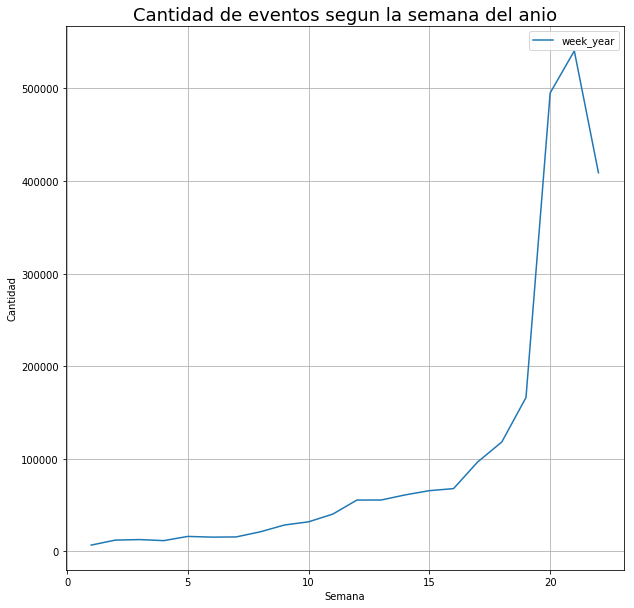

In [159]:
plot_events_per_week = events_count_per_week[['week_year']].plot.line(grid=True, figsize=(10,10))
plot_events_per_week.set_title("Cantidad de eventos segun la semana del anio", fontsize=18)
plot_events_per_week.set_xlabel("Semana")
plot_events_per_week.set_ylabel("Cantidad")

Vemos como justamente el mayor salto se da de la semana 19 a la semana 20 del año.
Cabe aclarar que la caída en el gráfico se debe a que de la última semana hay dos días de junio de los cuales no se tiene información.

La semana 19 del año empezó el 7 de mayo y la semana 20 empezó el 14 de mayo.

Aún así agregaremos el feature de "en qué semana del mes tiende a hacer más eventos el usuario".


In [41]:
eventos['cant_ev_primer_semana_mes'] = (eventos.month_week == 1).astype(int)
eventos['cant_ev_segunda_semana_mes'] = (eventos.month_week == 2).astype(int)
eventos['cant_ev_tercera_semana_mes'] = (eventos.month_week == 3).astype(int)
eventos['cant_ev_cuarta_semana_mes'] = (eventos.month_week == 4).astype(int)

df = eventos.groupby(['person']).agg({
    'cant_ev_primer_semana_mes': 'sum',
    'cant_ev_segunda_semana_mes': 'sum',
    'cant_ev_tercera_semana_mes': 'sum',
    'cant_ev_cuarta_semana_mes': 'sum'
})
df['semana_del_mes_moda'] = df.idxmax(axis=1)
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_primer_semana_mes'), 
    'semana_del_mes_moda'
] = 1
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_segunda_semana_mes'), 
    'semana_del_mes_moda'
] = 2
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_tercera_semana_mes'), 
    'semana_del_mes_moda'
] = 3
df.loc[
    (df['semana_del_mes_moda'] == 'cant_ev_cuarta_semana_mes'), 
    'semana_del_mes_moda'
] = 4
usuarios_y_semana_del_mes_moda = df.reset_index()
usuarios_y_semana_del_mes_moda.head(10)

,person,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,semana_del_mes_moda
0,0008ed71,0,0,6,0,3
1,00091926,44,121,188,95,3
2,00091a7a,0,0,0,10,4
3,000ba417,0,0,68,138,4
4,000c79fe,0,0,0,17,4
5,000e4d9e,0,0,215,196,3
6,000e619d,0,0,68,0,3
7,001001be,0,0,67,1,3
8,0010e89a,0,0,0,4,4
9,0016c4b5,0,0,0,4,4


In [42]:
usuarios_y_semana_del_mes_moda.semana_del_mes_moda.value_counts()

4    22024
3    12644
2     2494
1     1667
Name: semana_del_mes_moda, dtype: int64

In [43]:
user_features5 = user_features4.merge(usuarios_y_semana_del_mes_moda, how='inner', on='person')
user_features5
# user_features5.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,franja_horaria_moda,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,condicion_de_producto_moda,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,semana_del_mes_moda
0,4886f805,1,0,0,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada,0,4,1,0,excelentes,0,0,9,0,3
1,ad93850f,5,0,0,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada,10,4,7,0,buenos,0,13,45,7,3
2,0297fc1e,95,0,0,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,45,202,169,cant_ev_tarde,246,46,119,0,buenos,67,99,151,250,4
3,2d681dd8,2,0,0,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche,14,0,0,0,buenos,0,0,10,16,4
4,cccea85e,22,0,0,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,0,120,561,cant_ev_noche,201,191,347,1,muy buenos,104,213,249,270,4
5,4c8a8b93,20,0,0,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,2,81,67,cant_ev_madrugada,62,76,39,2,excelentes,0,0,255,2,3
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,2,0,15,cant_ev_noche,8,0,2,0,buenos,0,0,25,0,3
7,29ebb414,4,0,0,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,0,9,6,cant_ev_madrugada,2,4,3,0,excelentes,0,0,35,0,3
8,de8fe91b,2,0,0,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada,8,8,12,0,muy buenos,0,0,53,0,3
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada,7,0,0,0,buenos,0,0,20,0,3


### Análisis de usuarios que compraron y que no compraron en junio

En base a los labels que tenemos del set de entrenamiento, estudiaremos a los usuarios que compraron y a los que no compraron a fin de poder sacar features.

In [44]:
compradores = labels.loc[labels.label == 1]
no_compradores = labels.loc[labels.label == 0]

# Analisis de la cantidad de eventos total de usuarios compradores y no compradores segun la semana del mes
entrenamiento_y_semana_del_mes = labels.merge(usuarios_y_semana_del_mes_moda, how='inner', on='person')
entrenamiento_y_semana_del_mes['comprador'] = entrenamiento_y_semana_del_mes['label']
entrenamiento_y_semana_del_mes = entrenamiento_y_semana_del_mes.drop(['label'], axis=1)
entrenamiento_y_semana_del_mes.head()

,person,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,semana_del_mes_moda,comprador
0,0566e9c1,0,0,0,68,4,0
1,6ec7ee77,0,0,0,2,4,0
2,abe7a2fb,47,17,0,32,1,0
3,34728364,0,0,3,34,4,0
4,87ed62de,0,0,17,0,3,0


In [45]:
grouped = entrenamiento_y_semana_del_mes.groupby('comprador').agg({
    'cant_ev_primer_semana_mes': 'sum',
    'cant_ev_segunda_semana_mes': 'sum',
    'cant_ev_tercera_semana_mes': 'sum',
    'cant_ev_cuarta_semana_mes': 'sum'
})

grouped

,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes
comprador,,,,
0,99147,142944,319852,510259
1,15396,14976,21763,47549


Text(0,0.5,'Porcentaje de conversiones del mes')

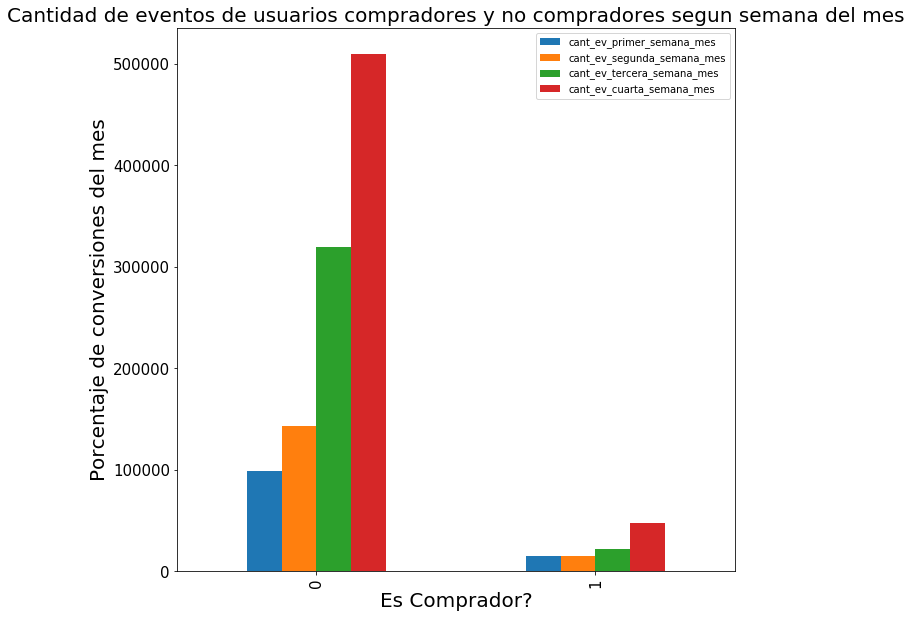

In [46]:
plot = grouped.plot.bar(
    figsize=(10, 10), 
    fontsize=15,
)
plot.set_title("Cantidad de eventos de usuarios compradores y no compradores segun semana del mes", fontsize=20)
plot.set_xlabel("Es Comprador?", fontsize=20)
plot.set_ylabel("Porcentaje de conversiones del mes", fontsize=20)

Trataremos de ver una secuencia de eventos en los usuarios que compraron en junio

In [47]:
eventos_compradores = eventos.loc[eventos['label'] == 1.0]
eventos_compradores_dummies = eventos_compradores
eventos_compradores_dummies['ad campaign hit'] = (eventos_compradores.event == 'ad campaign hit').astype(int)
eventos_compradores_dummies['brand listing'] = (eventos_compradores.event == 'brand listing').astype(int)
eventos_compradores_dummies['checkout'] = (eventos_compradores.event == 'checkout').astype(int)
eventos_compradores_dummies['conversion'] = (eventos_compradores.event == 'conversion').astype(int)
eventos_compradores_dummies['generic listing'] = (eventos_compradores.event == 'generic listing').astype(int)
eventos_compradores_dummies['lead'] = (eventos_compradores.event == 'lead').astype(int)
eventos_compradores_dummies['search engine hit'] = (eventos_compradores.event == 'search engine hit').astype(int)
eventos_compradores_dummies['searched products'] = (eventos_compradores.event == 'searched products').astype(int)
eventos_compradores_dummies['staticpage_ev'] = (eventos_compradores.event == 'staticpage').astype(int)
eventos_compradores_dummies['viewed product'] = (eventos_compradores.event == 'viewed product').astype(int)
eventos_compradores_dummies['visited site'] = (eventos_compradores.event == 'visited site').astype(int)
eventos_compradores_dummies

/home/ariel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ariel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ariel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,label,hour,month,week_year,week,year,day_week,day_year,month_day,is_weekend,geo_region,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,cant_total_eventos,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,month_week,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage_ev,viewed product,visited site
31,2018-05-18 00:29:42,viewed product,43790d8f,NaN,10378.0,Motorola Moto G4 Plus,Bom,32GB,Bambu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
42,2018-05-18 00:27:16,viewed product,43790d8f,NaN,10378.0,Motorola Moto G4 Plus,Bom,32GB,Bambu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
43,2018-05-18 00:26:47,viewed product,43790d8f,NaN,10464.0,Motorola Moto G4 Play,Excelente,16GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
46,2018-05-18 00:25:24,viewed product,43790d8f,NaN,318.0,iPhone 5s,Muito Bom,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
48,2018-05-18 00:24:52,viewed product,43790d8f,NaN,6791.0,Samsung Galaxy S5 New Edition Duos,Bom,16GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
54,2018-05-18 00:23:38,viewed product,43790d8f,NaN,12522.0,Motorola Moto G5,Excelente,32GB,Platinum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
56,2018-05-18 00:23:22,viewed product,43790d8f,NaN,12522.0,Motorola Moto G5,Excelente,32GB,Platinum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
60,2018-05-18 00:22:58,checkout,43790d8f,NaN,10378.0,Motorola Moto G4 Plus,Bom,32GB,Bambu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
62,2018-05-18 00:22:21,search engine hit,9bb3af27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
94,2018-05-18 00:54:37,viewed product,fc278339,NaN,9287.0,Samsung Galaxy J7 Prime,Muito Bom,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [48]:
eventos_compradores_week_year = eventos_compradores_dummies.groupby(['person', 'week_year']).agg({
    'ad campaign hit': 'sum',
    'brand listing': 'sum',
    'checkout': 'sum',
    'conversion': 'sum',
    'generic listing': 'sum',
    'lead': 'sum',
    'search engine hit': 'sum',
    'searched products': 'sum',
    'staticpage_ev': 'sum',
    'viewed product': 'sum',
    'visited site': 'sum'
})

eventos_compradores_week_year.reset_index(inplace=True)
eventos_compradores_week_year['total_eventos_semana'] = (\
    eventos_compradores_week_year['ad campaign hit'] +
    eventos_compradores_week_year['brand listing'] +
    eventos_compradores_week_year['staticpage_ev'] +
    eventos_compradores_week_year['visited site'] +
    eventos_compradores_week_year['searched products'] +
    eventos_compradores_week_year['conversion'] +
    eventos_compradores_week_year['viewed product'] +
    eventos_compradores_week_year['lead'] +
    eventos_compradores_week_year['search engine hit'] +
    eventos_compradores_week_year['generic listing'] +
    eventos_compradores_week_year['checkout']
)                                                        
eventos_compradores_week_year.sort_values(by='person')
print("Cantidad de usuarios que sabemos que compraron en junio:", eventos_compradores_week_year.person.value_counts().size)
eventos_compradores_week_year

Cantidad de usuarios que sabemos que compraron en junio: 980


,person,week_year,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage_ev,viewed product,visited site,total_eventos_semana
0,003476c0,7,2,0,0,0,2,0,2,15,0,0,2,23
1,003476c0,10,0,0,0,0,0,0,0,4,0,1,1,6
2,003476c0,19,4,0,0,0,0,0,4,0,0,5,1,14
3,003d4cac,12,0,0,0,0,0,0,0,0,0,0,1,1
4,003d4cac,15,1,0,1,0,0,0,0,0,0,1,1,4
5,003d4cac,17,1,0,0,0,0,0,0,0,0,1,1,3
6,003dd965,20,0,2,0,0,1,0,1,0,0,0,1,5
7,0042421c,9,0,0,0,0,0,0,1,0,0,5,1,7
8,0042421c,15,1,5,0,0,2,0,1,0,0,5,1,15
9,006671fd,17,0,0,0,0,0,0,1,0,0,15,2,18


In [49]:
antiguos_compradores = (eventos.loc[eventos.event == 'conversion'])['person'].drop_duplicates().to_frame()
antiguos_compradores.head()

,person
195,49c19e32
724,39df97e0
744,380c0e60
1198,35ee0cc8
2124,c5a0bc36


In [50]:
eventos_compradores_junio_reincidentes = eventos_compradores_week_year.merge(antiguos_compradores, on='person', how='inner')
print("Cant de usuarios que compraron en junio y ya habian comprado", eventos_compradores_junio_reincidentes.person.value_counts().size)
eventos_compradores_junio_reincidentes

Cant de usuarios que compraron en junio y ya habian comprado 197


,person,week_year,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage_ev,viewed product,visited site,total_eventos_semana
0,03db7c49,22,0,0,0,3,0,0,0,0,0,0,2,5
1,043ec736,7,6,6,3,0,0,0,7,0,1,17,1,41
2,043ec736,12,6,0,12,0,0,0,5,0,0,17,0,40
3,043ec736,13,8,2,31,1,69,1,5,0,0,92,19,228
4,043ec736,14,4,1,3,0,18,0,3,0,0,14,6,49
5,043ec736,16,2,1,0,0,8,0,2,0,0,13,3,29
6,043ec736,17,12,11,16,0,43,0,17,0,1,39,21,160
7,043ec736,18,4,0,1,0,3,0,0,0,0,8,5,21
8,0457712f,6,1,0,0,0,0,0,0,0,0,0,1,2
9,0457712f,7,0,6,0,0,0,0,0,0,0,1,1,8


Con estas dos últimas tablas se puede intentar de analizar un comportamiento de los usuarios que compraron en junio y en particular los que compraron en junio pero ya habían comprado antes en trocafone.

### Análisis de usuarios más activos en fin de semana o días de semana

Como se vio en el TP1 el comportamiento de los usuarios o cómo éstos accedían a Trocafone variaba si se trataba de un día de semana o si era fin de semana. Investigando en Internet se encontró que las plataformas de eCommerce suelen vender en mayor cantidad los fines de semana. Haremos el análisis de la información de eventos de conversión y el día correspondiente de la semana para evaluar esto. Así determinaremos si es un feature interesante un usuario que es más activo en fines de semana que en días de semana.

In [51]:
conversiones_segun_parte_de_la_semana = eventos.loc[eventos['event'] == 'conversion', 'is_weekend']
conversiones_segun_parte_de_la_semana.value_counts(normalize=True)

False    0.850374
True     0.149626
Name: is_weekend, dtype: float64

In [52]:
eventos.is_weekend.value_counts(normalize=True)

False    0.803135
True     0.196865
Name: is_weekend, dtype: float64

Aquí podemos observar como el 20% de todos los eventos ocurrieron en fin de semana. Menos porcentaje aún fue de las conversiones en los fines de semana con tan solo casi el 15%. Pareciera entonces que las conversiones son más propensas a suceder los días de semana.

Entonces buscaremos el porcentaje de eventos en fin de semana para tener una métrica sobre esta característica

In [53]:
usuarios_porcentaje_eventos_fin_de_semana = eventos.groupby('person').agg({
    'is_weekend': 'mean'
})
usuarios_porcentaje_eventos_fin_de_semana.reset_index(inplace=True)
# Cambio el nombre de la columna
usuarios_porcentaje_eventos_fin_de_semana['porcentaje_eventos_en_fin_de_semana'] = usuarios_porcentaje_eventos_fin_de_semana.is_weekend
usuarios_porcentaje_eventos_fin_de_semana = usuarios_porcentaje_eventos_fin_de_semana.drop(['is_weekend'], axis=1)
usuarios_porcentaje_eventos_fin_de_semana.sample(10)

,person,porcentaje_eventos_en_fin_de_semana
27866,b8476e3c,0.162791
35043,e7032d03,0.000000
16981,7041ff4b,0.000000
8528,38c24dda,0.258741
4075,1b119382,0.000000
17132,71564880,0.222222
29618,c3a004db,0.000000
13174,569eb076,0.000000
19674,82853c43,0.000000
4716,1f980dd9,0.000000


In [54]:
user_features6 = user_features5.merge(usuarios_porcentaje_eventos_fin_de_semana, how='inner', on='person')
user_features6
# user_features6.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,franja_horaria_moda,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,condicion_de_producto_moda,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,semana_del_mes_moda,porcentaje_eventos_en_fin_de_semana
0,4886f805,1,0,0,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada,0,4,1,0,excelentes,0,0,9,0,3,0.000000
1,ad93850f,5,0,0,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada,10,4,7,0,buenos,0,13,45,7,3,0.000000
2,0297fc1e,95,0,0,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,45,202,169,cant_ev_tarde,246,46,119,0,buenos,67,99,151,250,4,0.162257
3,2d681dd8,2,0,0,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche,14,0,0,0,buenos,0,0,10,16,4,0.615385
4,cccea85e,22,0,0,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,0,120,561,cant_ev_noche,201,191,347,1,muy buenos,104,213,249,270,4,0.050239
5,4c8a8b93,20,0,0,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,2,81,67,cant_ev_madrugada,62,76,39,2,excelentes,0,0,255,2,3,0.354086
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,2,0,15,cant_ev_noche,8,0,2,0,buenos,0,0,25,0,3,0.000000
7,29ebb414,4,0,0,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,0,9,6,cant_ev_madrugada,2,4,3,0,excelentes,0,0,35,0,3,0.257143
8,de8fe91b,2,0,0,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada,8,8,12,0,muy buenos,0,0,53,0,3,0.000000
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada,7,0,0,0,buenos,0,0,20,0,3,0.000000


### Análisis según modelo
Ahora estudiaremos los modelos que más son comprados. Así luego tratamos de relacionar a los usuarios con los modelos que suelen buscar en la plataforma, si es un modelo muy solicitado posiblemente sea más probable que realice una conversión

In [55]:
conversiones = eventos.loc[eventos.event == 'conversion']
conversiones.model.value_counts()

Samsung Galaxy J5                        519
iPhone 5s                                496
iPhone 6                                 398
iPhone 6S                                307
Motorola Moto G2 3G Dual                 272
Samsung Galaxy J7 Prime                  219
Motorola Moto G4 Plus                    198
Samsung Galaxy S7                        190
Samsung Galaxy S6 Flat                   178
Samsung Galaxy S7 Edge                   133
Samsung Galaxy J7                        123
iPhone 4S                                122
Samsung Galaxy S8                        114
iPhone 5c                                110
iPhone 7 Plus                            101
iPhone 6 Plus                            101
Samsung Galaxy J2 Prime TV               101
Samsung Galaxy S6 Edge                    99
Samsung Galaxy A5 2017                    98
Samsung Galaxy Gran Prime Duos TV         97
Samsung Galaxy S5                         97
Samsung Galaxy A5                         92
Samsung Ga

Aquí observamos que lo más comprado es iPhone, Samsung y Motorola. Reduciremos los modelos a estos tres y "otro" para tener una variable categórica más reducida

In [56]:
# Categorizamos los modelos
eventos.model.fillna('NaN', inplace=True)
eventos['modelo_reducido'] = np.nan

eventos.loc[
    eventos.model.str.contains("iPhone"),
    'modelo_reducido'
] = 'iPhone'

eventos.loc[
    eventos.model.str.contains("Samsung"),
    'modelo_reducido'
] = 'Samsung'

eventos.loc[
    eventos.model.str.contains("Motorola"),
    'modelo_reducido'
] = 'Motorola'

eventos.loc[
    (~eventos.model.str.contains("iPhone")) & 
    (~eventos.model.str.contains("Motorola")) &
    (~eventos.model.str.contains("Samsung")) &
    (eventos.model != 'NaN'),
    'modelo_reducido'
] = 'Otro'

In [57]:
eventos.modelo_reducido.value_counts()

iPhone      593603
Samsung     501307
Motorola    162914
Otro         63689
Name: modelo_reducido, dtype: int64

In [58]:
eventos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,label,hour,month,week_year,week,year,day_week,day_year,month_day,is_weekend,geo_region,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,cant_total_eventos,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,month_week,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,modelo_reducido
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,3,0,0,1,0,Samsung
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,3,0,0,1,0,iPhone
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,3,0,0,1,0,iPhone
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,3,0,0,1,0,iPhone
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5,20,20,2018,4,138,18,False,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,3,0,0,1,0,Otro


In [59]:
# Vemos los eventos que tienen el campo de modelo

eventos_con_modelo = eventos[['event', 'model']]
eventos_con_modelo_filtrado = eventos_con_modelo.loc[eventos_con_modelo.model != 'NaN']
eventos_con_modelo_filtrado.event.value_counts()

viewed product    1248124
checkout            65315
conversion           7091
lead                  983
Name: event, dtype: int64

Agregaremos a los usuarios el **modelo reducido moda**

In [60]:
eventos['cant_modelo_iphone'] = (eventos.modelo_reducido == 'iPhone').astype(int)
eventos['cant_modelo_samsung'] = (eventos.modelo_reducido == 'Samsung').astype(int)
eventos['cant_modelo_motorola'] = (eventos.modelo_reducido == 'Motorola').astype(int)
eventos['cant_modelo_otro'] = (eventos.modelo_reducido == 'Otro').astype(int)
eventos['porcentaje_modelo_iphone'] = (eventos.modelo_reducido == 'iPhone').astype(int)
eventos['porcentaje_modelo_samsung'] = (eventos.modelo_reducido == 'Samsung').astype(int)
eventos['porcentaje_modelo_motorola'] = (eventos.modelo_reducido == 'Motorola').astype(int)
eventos['porcentaje_modelo_otro'] = (eventos.modelo_reducido == 'Otro').astype(int)

print(eventos.modelo_reducido.size)
modelos_sin_nan = eventos[eventos.modelo_reducido.notnull()]
print(modelos_sin_nan.modelo_reducido.size)

2341681
1321513


In [61]:
df = modelos_sin_nan.groupby(['person']).agg({
    'cant_modelo_iphone': 'sum',
    'cant_modelo_samsung': 'sum',
    'cant_modelo_motorola': 'sum',
    'cant_modelo_otro': 'sum',
    'porcentaje_modelo_iphone': 'mean',
    'porcentaje_modelo_samsung': 'mean',
    'porcentaje_modelo_motorola': 'mean',
    'porcentaje_modelo_otro': 'mean'
})
df['modelo_moda'] = df.idxmax(axis=1)
df.loc[
    (df['modelo_moda'] == 'cant_modelo_iphone') , 
    'modelo_moda'
] = 'iPhone'
df.loc[
    (df['modelo_moda'] == 'cant_modelo_samsung') , 
    'modelo_moda'
] = 'Samsung'
df.loc[
    (df['modelo_moda'] == 'cant_modelo_motorola') , 
    'modelo_moda'
] = 'Motorola'
df.loc[
    (df['modelo_moda'] == 'cant_modelo_otro') , 
    'modelo_moda'
] = 'Otro'
usuarios_y_modelo = df.reset_index()
usuarios_y_modelo.head(10)

,person,cant_modelo_iphone,cant_modelo_samsung,cant_modelo_motorola,cant_modelo_otro,porcentaje_modelo_iphone,porcentaje_modelo_samsung,porcentaje_modelo_motorola,porcentaje_modelo_otro,modelo_moda
0,0008ed71,1,1,0,1,0.333333,0.333333,0.000000,0.333333,iPhone
1,00091926,253,61,55,5,0.676471,0.163102,0.147059,0.013369,iPhone
2,00091a7a,3,0,0,0,1.000000,0.000000,0.000000,0.000000,iPhone
3,000ba417,8,110,37,5,0.050000,0.687500,0.231250,0.031250,Samsung
4,000c79fe,4,0,0,0,1.000000,0.000000,0.000000,0.000000,iPhone
5,000e4d9e,21,301,2,16,0.061765,0.885294,0.005882,0.047059,Samsung
6,000e619d,7,12,7,3,0.241379,0.413793,0.241379,0.103448,Samsung
7,001001be,45,0,0,0,1.000000,0.000000,0.000000,0.000000,iPhone
8,0010e89a,0,2,0,0,0.000000,1.000000,0.000000,0.000000,Samsung
9,0016c4b5,0,2,0,0,0.000000,1.000000,0.000000,0.000000,Samsung


In [62]:
# Hay que tener cuidado porque algunos usuarios no tienen modelo moda
# Esto puede ser por el tipo de eventos que generaron
usuarios_y_modelo.person.size

38256

In [63]:
usuarios_y_modelo.modelo_moda.value_counts()

Samsung     16548
iPhone      16493
Motorola     4222
Otro          993
Name: modelo_moda, dtype: int64

In [64]:
user_features7 = user_features6.merge(usuarios_y_modelo, how='left', on='person')
user_features7
# user_features7.to_csv('../dataset/features_ariel.csv')

,person,cant_accesos_southeast,cant_accesos_northeast,cant_accesos_south,cant_accesos_center_west,cant_accesos_north,time_first_event,time_last_event,how_long_ago_was_first_event,how_long_ago_was_last_event,first_and_last_event_distance,cant_total_eventos,first_and_last_event_distance_in_days,mean_events_per_day,cant_ev_madrugada,cant_ev_manana,cant_ev_tarde,cant_ev_noche,franja_horaria_moda,cant_buenos,cant_excelentes,cant_muy_buenos,cant_nuevos,condicion_de_producto_moda,cant_ev_primer_semana_mes,cant_ev_segunda_semana_mes,cant_ev_tercera_semana_mes,cant_ev_cuarta_semana_mes,semana_del_mes_moda,porcentaje_eventos_en_fin_de_semana,cant_modelo_iphone,cant_modelo_samsung,cant_modelo_motorola,cant_modelo_otro,porcentaje_modelo_iphone,porcentaje_modelo_samsung,porcentaje_modelo_motorola,porcentaje_modelo_otro,modelo_moda
0,4886f805,1,0,0,0,0,2018-05-18 00:07:22,2018-05-18 00:30:30,13 days 23:52:38,13 days 23:29:30,0 days 00:23:08,9,1,9.000000,9,0,0,0,cant_ev_madrugada,0,4,1,0,excelentes,0,0,9,0,3,0.000000,0.0,5.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,Samsung
1,ad93850f,5,0,0,0,0,2018-05-14 23:50:22,2018-05-22 22:50:54,17 days 00:09:38,9 days 01:09:06,7 days 23:00:32,65,8,8.125000,34,0,0,31,cant_ev_madrugada,10,4,7,0,buenos,0,13,45,7,3,0.000000,21.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,iPhone
2,0297fc1e,95,0,0,0,0,2018-01-09 22:56:34,2018-05-28 11:50:12,142 days 01:03:26,3 days 12:09:48,138 days 12:53:38,567,139,4.079137,151,45,202,169,cant_ev_tarde,246,46,119,0,buenos,67,99,151,250,4,0.162257,405.0,2.0,0.0,5.0,0.983010,0.004854,0.000000,0.012136,iPhone
3,2d681dd8,2,0,0,0,0,2018-05-18 00:08:29,2018-05-27 19:42:49,13 days 23:51:31,4 days 04:17:11,9 days 19:34:20,26,10,2.600000,10,0,0,16,cant_ev_noche,14,0,0,0,buenos,0,0,10,16,4,0.615385,6.0,0.0,8.0,0.0,0.428571,0.000000,0.571429,0.000000,Motorola
4,cccea85e,22,0,0,0,0,2018-05-07 22:32:59,2018-05-31 14:38:30,24 days 01:27:01,0 days 09:21:30,23 days 16:05:31,836,24,34.833333,155,0,120,561,cant_ev_noche,201,191,347,1,muy buenos,104,213,249,270,4,0.050239,8.0,34.0,517.0,181.0,0.010811,0.045946,0.698649,0.244595,Motorola
5,4c8a8b93,20,0,0,0,0,2018-05-18 00:25:14,2018-05-22 00:33:18,13 days 23:34:46,9 days 23:26:42,4 days 00:08:04,257,5,51.400000,107,2,81,67,cant_ev_madrugada,62,76,39,2,excelentes,0,0,255,2,3,0.354086,176.0,3.0,0.0,0.0,0.983240,0.016760,0.000000,0.000000,iPhone
6,1b9f7cf6,0,0,0,0,0,2018-05-17 19:25:08,2018-05-21 10:13:50,14 days 04:34:52,10 days 13:46:10,3 days 14:48:42,25,4,6.250000,8,2,0,15,cant_ev_noche,8,0,2,0,buenos,0,0,25,0,3,0.000000,10.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,iPhone
7,29ebb414,4,0,0,0,0,2018-05-18 00:36:16,2018-05-20 17:37:37,13 days 23:23:44,11 days 06:22:23,2 days 17:01:21,35,3,11.666667,20,0,9,6,cant_ev_madrugada,2,4,3,0,excelentes,0,0,35,0,3,0.257143,9.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,iPhone
8,de8fe91b,2,0,0,0,0,2018-05-18 00:36:03,2018-05-21 22:37:28,13 days 23:23:57,10 days 01:22:32,3 days 22:01:25,53,4,13.250000,34,0,0,19,cant_ev_madrugada,8,8,12,0,muy buenos,0,0,53,0,3,0.000000,5.0,17.0,6.0,0.0,0.178571,0.607143,0.214286,0.000000,Samsung
9,45baf068,0,0,0,0,0,2018-05-18 00:39:56,2018-05-18 00:54:48,13 days 23:20:04,13 days 23:05:12,0 days 00:14:52,20,1,20.000000,20,0,0,0,cant_ev_madrugada,7,0,0,0,buenos,0,0,20,0,3,0.000000,0.0,7.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,Samsung


# Métrica sobre la evolución del interés de los usuarios

A continuación buscaremos medir como evoluciona el interés de los usuarios con el transcurso de los días del año. La idea básica de este *feature* es la siguiente:
* Si un usuario cada día genera más eventos, podemos afirmar que el interés del mismo está aumentando.
* Si un usuario cada día genera menos eventos, podemos afirmar que el interés del usuario está disminuyendo.
* Es necesario aplicar algún tipo de penalización si un usuario en un determinado día no genera ningún evento.

Haremos unos **line plots** para ver de manera más clara esta métrica y determinar como trabajarla.

In [65]:
eventos['cantidad_eventos'] = 1
eventos_dia_anio_usuario = eventos[['person', 'day_year', 'cantidad_eventos']]
eventos_dia_anio_usuario.head()

,person,day_year,cantidad_eventos
0,4886f805,138,1
1,ad93850f,138,1
2,0297fc1e,138,1
3,2d681dd8,138,1
4,cccea85e,138,1


In [66]:
ev_dia_anio_usuario_grouped = eventos_dia_anio_usuario.groupby(['person', 'day_year']).agg({
    'cantidad_eventos': 'sum'
})
ev_dia_anio_usuario_grouped.head(40)

cantidad_eventos
person   day_year                  
0008ed71 137                      6
00091926 123                      7
         125                     20
         126                      6
         127                     11
         128                      6
         129                      3
         130                      3
         131                     23
         132                      2
         133                     84
         135                     22
         136                      1
         137                     58
         138                     63
         140                     23
         141                     21
         142                     12
         143                     36
         146                     10
         147                     18
         149                      3
         151                     16
00091a7a 85                      10
000ba417 137                     68
         144                     79
         146                     59
000c79fe 149                     17
000e4d9e 136                    195
         141                     20
         142                     79
         143                      5
         144                     29
         145                      8
         148                      7
         149                     61
         150                      7
000e619d 135                     10
         136                      9
         137                     27

In [67]:
ev_dia_anio_usuario_reset = ev_dia_anio_usuario_grouped.reset_index()
ev_dia_anio_usuario_reset.head()

,person,day_year,cantidad_eventos
0,0008ed71,137,6
1,00091926,123,7
2,00091926,125,20
3,00091926,126,6
4,00091926,127,11


Definiremos una función para realizar los line plots buscados de un determinado usuario (en caso de no pasarse ningún usuario, se eligirá uno al azar).

In [68]:
def plot_users_events_per_day_of_year(df, u=None, plot_type='line'):
    user = u
    if user is None:
        user = df.person.sample(1).iloc[0]

    filtered = df.loc[df.person == user]
    
    if plot_type is 'line':
        plot = filtered.plot.line(x='day_year', y='cantidad_eventos', figsize=(10, 10), grid=True)
    else:
        plot = filtered.plot.scatter(x='day_year', y='cantidad_eventos', figsize=(10, 10), grid=True)
    plot.set_xlabel('Dia del anio', fontsize=30)
    plot.set_ylabel('Cantidad de eventos', fontsize=30)
    plot.set_title('Eventos segun dia del anio del usuario ' + user, fontsize=30)
    return plot
    

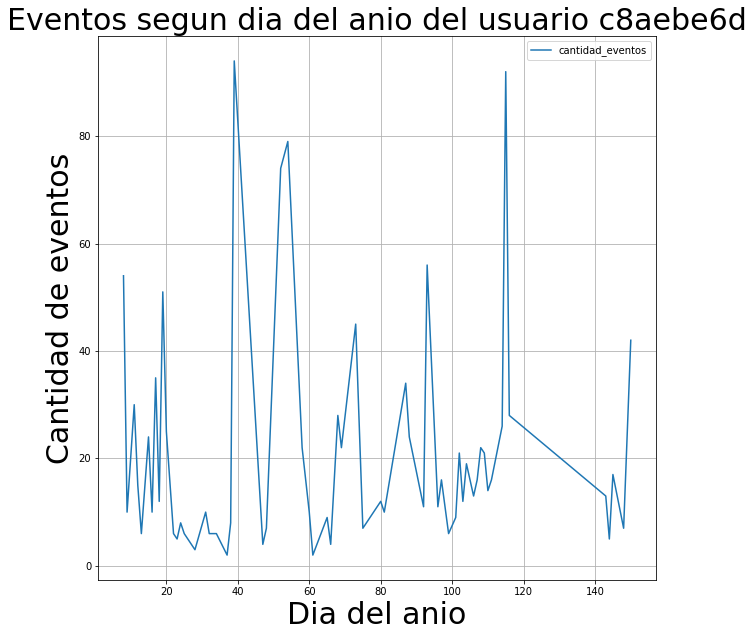

In [69]:
plot_users_events_per_day_of_year(ev_dia_anio_usuario_reset, plot_type='line', u='c8aebe6d')

Ahora definiremos la manera de calcular el interés. A esta función se le podrá aplicar *tunning* a medida que vemos como se comporta con los algoritmos de Machine Learning. Para una primer versión lo que haremos es calcular las derivadas aproximadas de las funciones `cantidad_eventos(dia_del_anio)` con la siguiente fórmula:
```
           cantidad_de_eventos(dia_i) - cantidad de eventos(dia_j)
interes = *********************************************************
                                dia_i - dia_j
```
Con *i > j*.

Además podemos crear un **lagged feature** tomando los últimos **N** días para calcular el interés.

In [70]:
def get_user_interest(df, last_n_days=151):
    ret = pd.DataFrame(columns=['person', 'interest_last_' + str(last_n_days) + '_days'])
    
    # Obtenemos los usuarios
    users = df.person.unique()
    
    # Filtramos los dias correspondientes. Tenemos datos de 151 dias del anio
    df_days_filtered = df.loc[(151 - df.day_year) < last_n_days]
    
    ret_index = 1
    for user in users:
        # if '00091926' in user or '00091a7a' in user or '000e4d9e' in user: # Para probar un usuario en particular
        
            # Filtramos segun el usuario
            user_events_per_day = df_days_filtered.loc[
                df_days_filtered.person == user, ['day_year', 'cantidad_eventos']
            ]
            
            # Inicializamos variables
            dia_i = False
            dia_j = False
            ev_i = False
            ev_j = False
            
            # Solo podemos procesar usuarios que tengan eventos en mas de un dia distinto
            if len(user_events_per_day.index) > 1:
                user_events_per_day = user_events_per_day.sort_values(by='day_year')
                interest = 0
                for index, row in user_events_per_day.iterrows():
                    if dia_j == False:
                        # print(row.day_year, row.cantidad_eventos)
                        # Si es la primer iteracion debemos saltear el calculo
                        dia_j = row.day_year
                        ev_j = row.cantidad_eventos
                        continue
                        
                    # Obtenemos indice actual en i
                    dia_i = row.day_year
                    ev_i = row.cantidad_eventos
                    
                    # Calculamos el 'interes'
                    interest += ((ev_i - ev_j) / (dia_i - dia_j))
                    
                    # Actualizamos indices j
                    dia_j = dia_i
                    ev_j = ev_i
                    # print(row.day_year, row.cantidad_eventos, interest)
                
                # Escribimos en el DataFrame que devolveremos
                ret.loc[ret_index] = [user, interest]
            else:
                ret.loc[ret_index] = [user, np.nan]
            
            # Sumamos el indice del DF a devolver
            ret_index += 1
    return ret

In [71]:
# Tomamos desde 2 dias porque con 1 dia solo no podemos aproximar una derivada
def process_lagged_interest(data, until_last_n_days=151):
    users_interest_lagged = data.person.drop_duplicates().to_frame()
    for i in range(2, until_last_n_days + 1):
        df = get_user_interest(data, last_n_days=i)
        users_interest_lagged = users_interest_lagged.merge(df, how='left', on='person')
        
    return users_interest_lagged
    

In [72]:
%%time
# users_interest_lagged = process_lagged_interest(ev_dia_anio_usuario_reset)
# No descomentar esta linea. Tarda casi 17hs en procesar todos los usuarios

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 28.6 µs


In [73]:
users_interest_lagged

NameError: name 'users_interest_lagged' is not defined

In [ ]:
user_features8 = user_features7.merge(users_interest_lagged, how='inner', on='person')
user_features8
# user_features8.to_csv('../dataset/features_ariel.csv')